<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

RANDOM_STATE = 2023

In [3]:
try:
    data = pd.read_csv('C:\\D\\Project\\datasets\\taxi.csv', parse_dates=[0], index_col=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.sort_index(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
data = data.resample('1H').sum()

In [9]:
decomposed = seasonal_decompose(data)

In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [11]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Вывод:** Модели будет легче предсказать спрос на больший временной промежуток, чем угадывать точечно каждые 10 минут. Суммировала данные по часу.

## Анализ

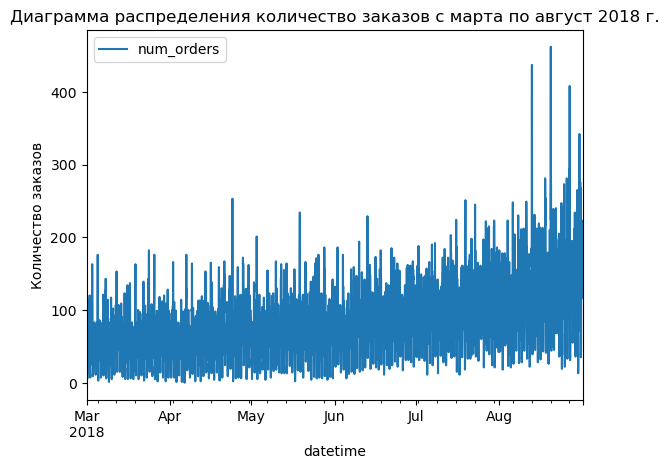

In [12]:
data.plot()
plt.title('Диаграмма распределения количество заказов с марта по август 2018 г.')
plt.ylabel('Количество заказов')
plt.show()

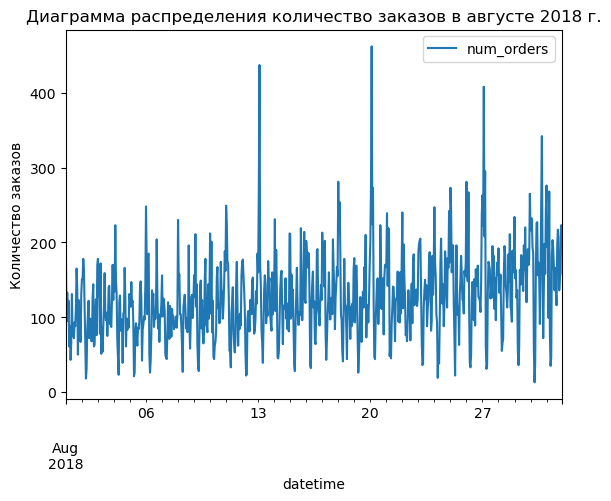

In [13]:
data['2018-08':].plot()
plt.title('Диаграмма распределения количество заказов в августе 2018 г.')
plt.ylabel('Количество заказов')
plt.show()

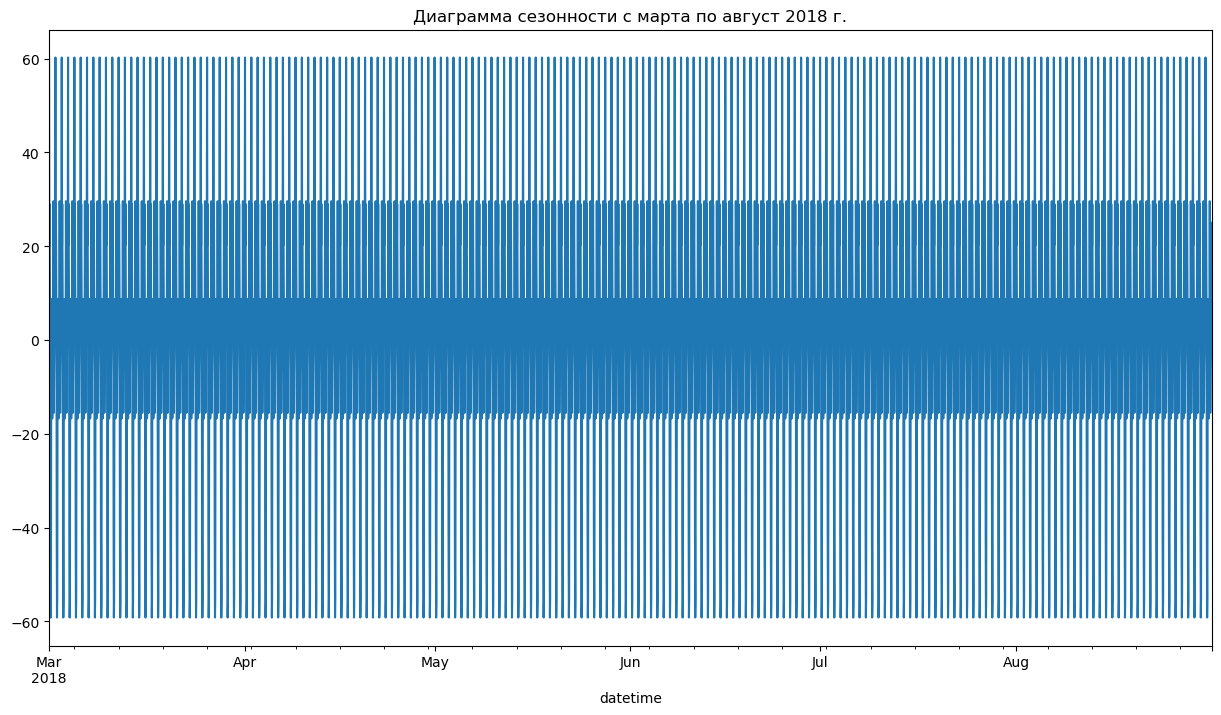

In [14]:
plt.figure(figsize=(15,8))
decomposed.seasonal.plot()
plt.title('Диаграмма сезонности с марта по август 2018 г.')
plt.show()

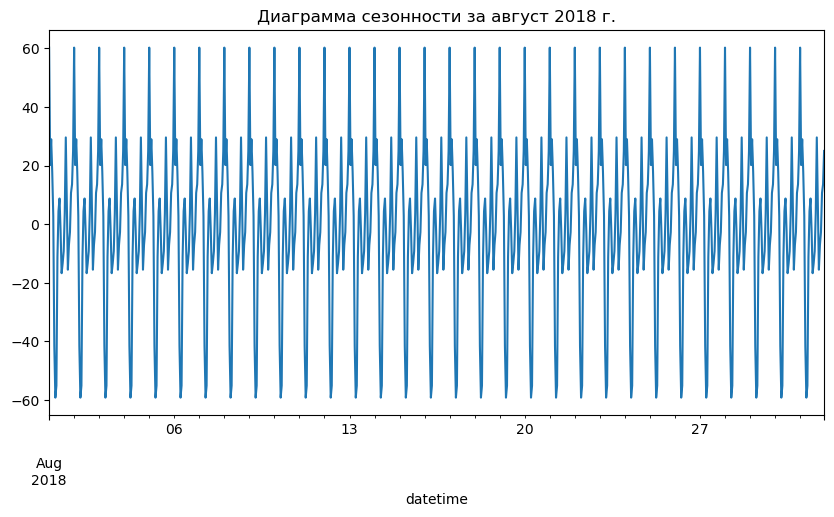

In [15]:
plt.figure(figsize=(10,5))
decomposed.seasonal['2018-08':].plot()
plt.title('Диаграмма сезонности за август 2018 г.')
plt.show()

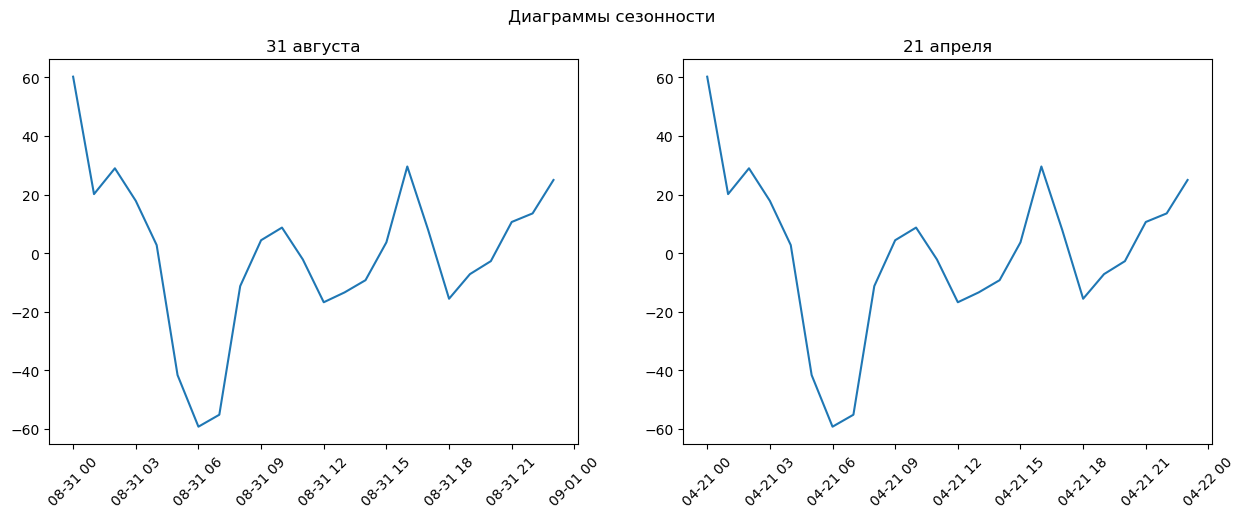

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(decomposed.seasonal['2018-08-31':'2018-08-31'])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('31 августа')

axes[1].plot(decomposed.seasonal['2018-04-21':'2018-04-21'])
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('21 апреля')

fig.suptitle('Диаграммы сезонности')

plt.show()

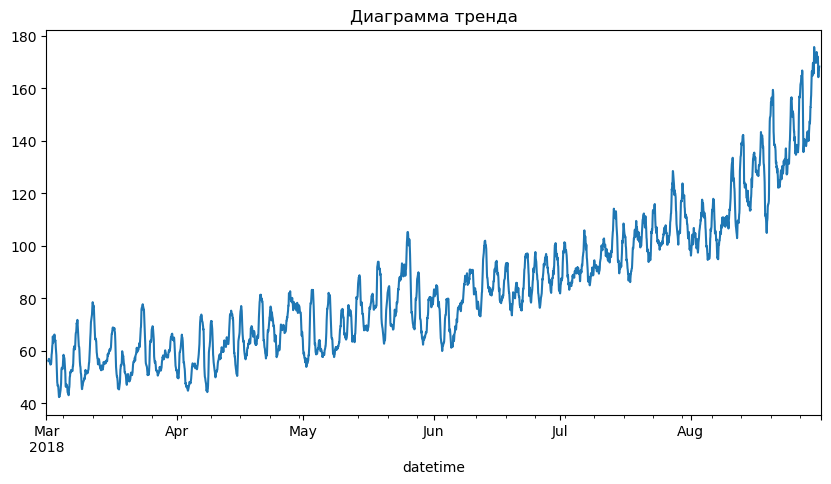

In [17]:
plt.figure(figsize=(10, 5))
decomposed.trend.plot()
plt.title('Диаграмма тренда')
plt.show()

**Вывод:** Есть тренд, летом начинается заметное увеличение заказов.

В раннее утро заказов мало. В позднее утро, когда все собираются на работу, и часа в 4 и после 6, когда многие заканчивают работать, заказы увеличиваются. Ночью, когда общественный транспорт не ходит, больше всего заказов.

Данные имеют нестационарный ряд.

Новые признаки, которые помогут модели лучше обучиться:
- День недели;
- Час;
- Лаг, каждые 24 часа, в течение недели;
- Скользящее среднее на 8 часов.

In [18]:
def add_features(df):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(24, 169, 24):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        data['rolling_mean'] = data['num_orders'].shift().rolling(8).mean()
    return data

## Обучение

In [19]:
new_data = add_features(data).dropna()
train, test = train_test_split(new_data, shuffle=False, test_size=.1)

features_train, target_train = train.drop(['num_orders'], axis=1), train['num_orders']
features_test, target_test = test.drop(['num_orders'], axis=1), test['num_orders']

In [20]:
train.head(25)

,num_orders,dayofweek,hour,lag_24,rolling_mean,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168
datetime,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,100.0,81.000,42.0,86.0,75.0,163.0,90.0,124.0
2018-03-08 01:00:00,78,3,1,121.0,93.125,75.0,176.0,60.0,108.0,120.0,85.0
2018-03-08 02:00:00,65,3,2,24.0,96.875,36.0,32.0,26.0,25.0,75.0,71.0
2018-03-08 03:00:00,68,3,3,66.0,92.625,49.0,51.0,42.0,64.0,64.0,66.0
2018-03-08 04:00:00,60,3,4,73.0,94.875,30.0,34.0,27.0,44.0,20.0,43.0
2018-03-08 05:00:00,6,3,5,10.0,92.875,36.0,16.0,22.0,15.0,11.0,6.0
2018-03-08 06:00:00,6,3,6,19.0,80.125,7.0,3.0,11.0,9.0,11.0,12.0
2018-03-08 07:00:00,19,3,7,17.0,65.000,10.0,14.0,12.0,17.0,7.0,15.0
2018-03-08 08:00:00,77,3,8,38.0,55.625,25.0,31.0,39.0,56.0,46.0,34.0


In [21]:
print(test.shape, new_data.shape)
print(test.shape[0] / new_data.shape[0])

(425, 11) (4248, 11)
0.10004708097928437


In [22]:
def rmse(predictions, targets, **kwargs):
    return (((predictions - targets) ** 2).mean())**.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [23]:
%%time
rfr = RandomForestRegressor()
parametrs = {
    'random_state': [RANDOM_STATE],
    'n_estimators': range(25, 126, 25),
    'max_depth': range(15, 31, 5)
}
tscv = TimeSeriesSplit()
grid_rfr = GridSearchCV(rfr, parametrs, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
grid_rfr.fit(features_train, target_train)
print(f'Параметры: {grid_rfr.best_params_}')
print(f'Лучшее RMSE: {grid_rfr.best_score_ * -1}')

Параметры: {'max_depth': 15, 'n_estimators': 125, 'random_state': 2023}
Лучшее RMSE: 22.904204708494763
Wall time: 9.41 s


In [24]:
%%time
lgbm = LGBMRegressor()
parametrs = {
    'random_state': [RANDOM_STATE],
    'n_estimators': range(25, 51, 5),
    'num_leaves': range(20, 51, 5),
    'max_depth': range(5, 26, 5),
}
grid_lgbm = GridSearchCV(lgbm, parametrs, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
print(f'Параметры: {grid_lgbm.best_params_}')
print(f'Лучшее RMSE: {grid_lgbm.best_score_ * -1}')

Параметры: {'max_depth': 5, 'n_estimators': 30, 'num_leaves': 25, 'random_state': 2023}
Лучшее RMSE: 22.619553618346345
Wall time: 4.08 s


In [25]:
%%time
cat = CatBoostRegressor()
parametrs = {
    'iterations': range(20, 31, 5),
    'depth': range(5, 16, 5),
    'random_seed': [RANDOM_STATE],
    'verbose': [False]
}
grid_cat = GridSearchCV(cat, parametrs, cv=tscv, scoring=rmse_scorer, n_jobs=-1)
grid_cat.fit(features_train, target_train)
print(f'Параметры: {grid_cat.best_params_}')
print(f'Лучшее RMSE: {grid_cat.best_score_ * -1}')

Параметры: {'depth': 5, 'iterations': 20, 'random_seed': 2023, 'verbose': False}
Лучшее RMSE: 23.881333358309615
Wall time: 1min 11s


In [26]:
pd.DataFrame({
    'RMSE': [round(i,2) for i in [grid_rfr.best_score_ * -1, grid_lgbm.best_score_ * -1, grid_cat.best_score_ * -1]]
},
    index=['RandomForest', 'LGBMRegressor', 'CatBoostRegressor']
)

,RMSE
RandomForest,22.90
LGBMRegressor,22.62
CatBoostRegressor,23.88


**Вывод:** Лучшее RMSE (`22.62`) у LGBMRegression с гиперпараметрами:
- max_depth: 5,
- n_estimators: 30,
- num_leaves: 25,
- random_state: 2023

## Тестирование

In [29]:
best_model = grid_lgbm.best_estimator_
predict_model = best_model.predict(features_test)
print(f'RMSE на тесте: {round(mean_squared_error(target_test, predict_model, squared=False),2)}')

RMSE на тесте: 39.92


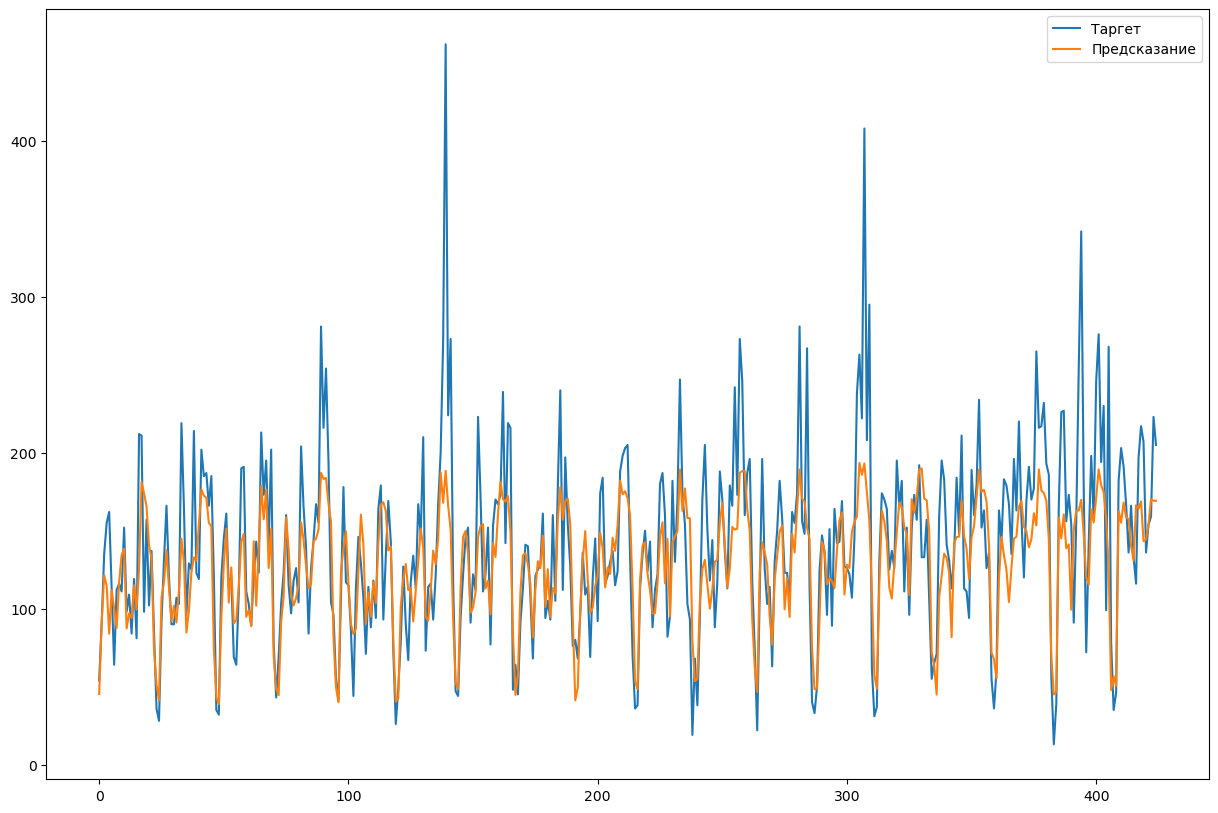

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(target_test.reset_index(drop=True), label='Таргет')
plt.plot(predict_model, label='Предсказание')
plt.legend()
plt.show()

**Вывод:** Данные имеют нестационарный временной ряд. Ночью пик заказов, ранним утром меньше всего заказов. В раннее утро заказов мало. В позднее утро, когда все собираются на работу, и часа в 4 и после 6, когда многие заканчивают работать, заказы увеличиваются. Ночью, когда общественный транспорт не ходит, больше всего заказов. 

Были добавлены признаки:
- День недели;
- Час;
- Лаг, каждые 24 часа, в течение недели;
- Скользящее среднее на 8 часов.

LGBMRegression (с гиперпараметрами max_depth: 5, n_estimators: 30, num_leaves: 25, random_state: 2023) показала на тестовой выборке RMSE 39.92.

У модели получается хорошо предсказывать, когда заказов обычное количество, либо когда их мало, имеются проблемы с большим количеством заказов.